# TensorBoardで可視化する

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

## データセット準備

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# training dataset
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=False, num_workers=2)

# test dataset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# helper function to show an image
def matplotlib_imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## ネットワーク構築

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Tensor Boardのセットアップ

In [4]:
writer = SummaryWriter('runs/CIFAR10_experiment_1')

#writer1 = SummaryWriter()
 
#writer2 = SummaryWriter(comment='_loss function')

#writer3 = SummaryWriter('logs/image')

- writer
    - 任意のログディレクトリを指定できる。今回は'runs/CIFAR10_experiment_1'が生成される
    
- writer1
    - ログディレクトリを指定しない場合は'./runs/(CURRENT_DATETIME_HOSTNAME)' が自動で生成される

- writer2
    - #writer1の様にlogdirを指定していない場合、commentを指定するとデフォルトのログディレクトリの後に続いてcommentが追加される

- writer3
    - '.runs/' 以外もディレクトリは生成できる（'./logs/image')

## 画像データをwriterに保存

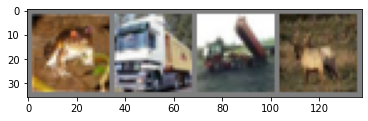

In [5]:
# get some training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of image
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)

# write to tensorboard
writer.add_image('four_CIFAR10_images', img_grid)

- `$ tensorboard --logdir=runs`
- ブラウザで https://localhost:6006 

## モデルの確認

In [6]:
net = Net()

writer.add_graph(net, images)
writer.close()

- グラフはダブルクリックすることで中身を見れる

## 学習の可視化

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

running_loss = 0.0
for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            # log the running loss
            writer.add_scalar('training_loss', running_loss / 1000,
                              epoch * len(trainloader) + i)
            #
            running_loss = 0.0
            
print('Finished Training')

Finished Training


## 学習モデルの評価

In [8]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [9]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)